### Goal: To test the boosting algorithms
- Datasets:
    - The loaded features have been already scaled, splitted, transformed by Kernel PCA-cosine and clustered. 
    
- Plan: 
    1. Load and inspect the features and targets
    2. Seperate the observations in train/validate/test into cluster 'dense core' (0) and cluster 'satellites' (1) and keep the dense cores.
    3. Compute the top 10 most frequent MoA annotations in cluster 'dense core'
    4. Create a list of classifiers: focus on 
    5. Test the For Loop classifiers on single label
    6. Run For Loop classifiers on classifier chain

In [19]:
# import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain

# Decision Tree (predict_proba)
from sklearn.tree import DecisionTreeClassifier

# Random Forest (predcit_proba)
from sklearn.ensemble import RandomForestClassifier

# AdaBoost (predict_proba)
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

# Nearest Neighbors (predict_proba)
from sklearn.neighbors import KNeighborsClassifier

# Neural Net (predict_proba)
from sklearn.neural_network import MLPClassifier

# Linear SVM (predict)
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, log_loss

import model

### 1. Load and inspect the features and targets

In [4]:
# Load the features and targets

X_train_cos_two = pd.read_csv('X_train_cos_two.csv', index_col=0)
X_validate_cos_two = pd.read_csv('X_validate_cos_two.csv', index_col=0)
X_test_cos_two = pd.read_csv('X_test_cos_two.csv', index_col=0)

Y_train = pd.read_csv('Y_train.csv', index_col=0)
Y_validate = pd.read_csv('Y_validate.csv', index_col=0)
Y_test = pd.read_csv('Y_test.csv', index_col=0)

# Print their shapes
X_train_cos_two.shape, X_validate_cos_two.shape, X_test_cos_two.shape, \
Y_train.shape, Y_validate.shape, Y_test.shape

((15802, 51), (3951, 51), (2195, 51), (15802, 206), (3951, 206), (2195, 206))

In [5]:
# Make sure the index match between X and Y

print((X_train_cos_two.index == Y_train.index).sum())
print((X_validate_cos_two.index == Y_validate.index).sum())
print((X_test_cos_two.index == Y_test.index).sum())

15802
3951
2195


In [6]:
# Take a peek at train features
X_train_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,-0.046098,-0.000499,0.032700,-0.090504,0.031419,-0.122123,0.024048,-0.122287,-0.012305,0
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,0.004647,0.002614,0.044699,0.061037,-0.002453,-0.014456,-0.020474,0.008282,0.037586,0


In [7]:
# Take a peek at validate features
X_validate_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_c3dcb40f3,-0.095262,0.304736,0.249410,-0.111197,0.057856,-0.063222,-0.016120,0.054633,0.165032,-0.038657,...,0.059683,-0.02128,-0.080636,-0.022468,0.010193,0.023441,-0.028692,0.053862,0.072372,0
id_f8620e4ca,-0.134914,0.106835,0.270053,-0.107940,-0.040384,-0.194361,0.152628,-0.014447,-0.029834,0.057959,...,-0.009219,-0.00217,-0.007370,-0.027853,-0.031368,0.000323,-0.065433,-0.050758,0.048525,0


In [7]:
# Take a peek at test features
X_test_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_e46fab631,-0.264368,-0.005719,0.092971,-0.328395,0.007406,-0.018449,-0.042042,-0.055791,0.082492,-0.004333,...,0.042677,0.028871,-0.023006,0.006879,-0.084260,0.030489,-0.015435,-0.090901,0.042381,0
id_354d3994d,0.392137,-0.125651,-0.209954,0.156944,-0.183358,0.266505,0.519936,0.154461,0.052577,0.050146,...,-0.022478,0.020033,-0.052790,-0.043385,0.012011,-0.038902,-0.025513,-0.013596,0.009735,1


**Takeaways**: Features and labels are successfully imported.

### 2. Seperate the observations into cluster 1 (dense core) and cluster 2 (satellites)

In [8]:
# Concat features and labels together

train = pd.concat([X_train_cos_two, Y_train], axis=1)
validate = pd.concat([X_validate_cos_two, Y_validate], axis=1)
test = pd.concat([X_test_cos_two, Y_test], axis=1)

# Print their shapes
train.shape, validate.shape, test.shape

((15802, 257), (3951, 257), (2195, 257))

In [9]:
# Seperate the train based on cluster labels

# Create the mask for the dense core
mask_core = (train.cluster == 0)

# Subtract the dense core
train_core = train[mask_core]

# Print the shape
print(train_core.shape)

# Take a peek at the df
train_core.head()

(13558, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,-0.116704,-0.175076,-0.216695,0.093239,0.098658,-0.023396,-0.040551,-0.069963,0.081209,-0.049178,...,0,0,0,0,0,0,0,0,0,0
id_d8f5ca938,-0.108337,0.198954,-0.001508,0.331887,-0.138065,-0.079667,-0.033503,-0.174493,-0.137442,0.065832,...,0,0,0,0,1,0,0,0,0,0
id_c4eaa645d,0.113585,-0.318411,0.101633,-0.034343,0.128269,-0.208788,-0.105685,0.149461,-0.098587,0.329119,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Seperate the validate based on cluster labels

# Create the mask for the dense core
mask_core = (validate.cluster == 0)

# Subtract the dense core
validate_core = validate[mask_core]

# Print the shape
print(validate_core.shape)

# Take a peek at the df
validate_core.head()

(3410, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_c3dcb40f3,-0.095262,0.304736,0.249410,-0.111197,0.057856,-0.063222,-0.016120,0.054633,0.165032,-0.038657,...,0,0,0,0,0,0,0,0,0,0
id_f8620e4ca,-0.134914,0.106835,0.270053,-0.107940,-0.040384,-0.194361,0.152628,-0.014447,-0.029834,0.057959,...,0,0,0,0,0,0,0,0,0,0
id_018eabd67,0.210457,0.239365,-0.164920,0.034534,0.272117,0.167090,0.046586,-0.259783,-0.143833,0.017687,...,0,0,0,0,0,0,0,0,0,0
id_1b31d6454,-0.037920,0.085548,0.091110,0.153108,-0.060493,-0.090420,-0.137237,0.078051,-0.030707,0.072345,...,0,0,0,0,0,0,0,0,0,0
id_4157cd98a,-0.108509,0.067244,-0.064803,-0.172227,-0.004254,-0.012358,-0.054628,0.094533,0.012555,0.065035,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Seperate the test based on cluster labels

# Create the mask for the dense core
mask_core = (test.cluster == 0)

# Subtract the dense core
test_core = test[mask_core]

# Print the shape
print(test_core.shape)

# Take a peek at the df
test_core.head()

(1892, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_e46fab631,-0.264368,-0.005719,0.092971,-0.328395,0.007406,-0.018449,-0.042042,-0.055791,0.082492,-0.004333,...,0,0,0,0,0,0,0,0,0,0
id_5c852c5fa,-0.113353,-0.292529,-0.019310,-0.156830,-0.081259,0.043071,0.028983,0.122399,0.071044,-0.084348,...,0,0,0,0,0,0,0,0,0,0
id_76de9b673,-0.022017,0.211754,-0.149465,-0.067840,0.140077,0.033733,0.054614,-0.075482,-0.032314,0.027665,...,0,0,0,0,0,0,0,0,0,0
id_5381a8f79,0.237520,0.262443,0.061341,-0.073582,0.029755,0.070180,0.059589,-0.051466,0.136650,0.087285,...,0,0,0,0,0,0,0,0,0,0
id_df1a8d0aa,0.009617,0.105377,-0.051351,-0.286780,0.205990,0.076437,0.112342,-0.079288,0.052905,0.021284,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Subtract the features: don't include the cluster column

X_train_core = train_core.iloc[:, 0:50]
X_validate_core = validate_core.iloc[:, 0:50]
X_test_core = test_core.iloc[:, 0:50]

# Print the shapes
X_train_core.shape, X_validate_core.shape, X_test_core.shape

((13558, 50), (3410, 50), (1892, 50))

In [13]:
# Subtract the targets: don't include the cluster column

Y_train_core = train_core.iloc[:, 51:]
Y_validate_core = validate_core.iloc[:, 51:]
Y_test_core = test_core.iloc[:, 51:]

# Print the shapes
Y_train_core.shape, Y_validate_core.shape, Y_test_core.shape

((13558, 206), (3410, 206), (1892, 206))

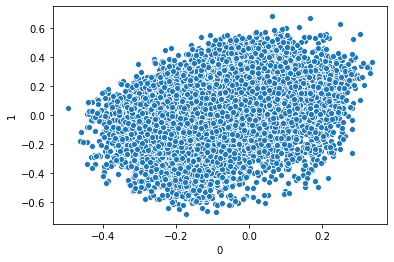

In [14]:
# Quick viz to confirm the correct separation

sns.scatterplot(data=X_train_core, x='0', y='1')
plt.show()

**Takeaways**: The cluster 'dense core' are successfully substracted from train/validate/test.

### 3. Define the top 10 most frequent MoA annotations in cluster dense core

In [15]:
# Compute top 13 most frequent MoA annotations in train and store in a set

top_labels_train = set(Y_train_core.sum(axis=0).sort_values(ascending=False).head(14).index)
top_labels_train

{'acetylcholine_receptor_antagonist',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'calcium_channel_blocker',
 'cyclooxygenase_inhibitor',
 'dna_inhibitor',
 'dopamine_receptor_antagonist',
 'egfr_inhibitor',
 'glutamate_receptor_antagonist',
 'kit_inhibitor',
 'pdgfr_inhibitor',
 'phosphodiesterase_inhibitor',
 'serotonin_receptor_antagonist',
 'sodium_channel_inhibitor'}

In [16]:
# Compute top 15 most frequent MoA annotations in validate and store in a set

top_labels_validate = set(Y_validate_core.sum(axis=0).sort_values(ascending=False).head(14).index)
top_labels_validate

{'acetylcholine_receptor_antagonist',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'calcium_channel_blocker',
 'cyclooxygenase_inhibitor',
 'dna_inhibitor',
 'dopamine_receptor_antagonist',
 'glucocorticoid_receptor_agonist',
 'glutamate_receptor_antagonist',
 'histamine_receptor_antagonist',
 'pdgfr_inhibitor',
 'phosphodiesterase_inhibitor',
 'serotonin_receptor_agonist',
 'serotonin_receptor_antagonist'}

In [17]:
# Compute top 15 most frequent MoA annotations in test and store in a set

top_labels_test = set(Y_test_core.sum(axis=0).sort_values(ascending=False).head(14).index)
top_labels_test

{'acetylcholine_receptor_antagonist',
 'adrenergic_receptor_antagonist',
 'calcium_channel_blocker',
 'cyclooxygenase_inhibitor',
 'dna_inhibitor',
 'dopamine_receptor_antagonist',
 'glucocorticoid_receptor_agonist',
 'glutamate_receptor_antagonist',
 'histamine_receptor_antagonist',
 'hmgcr_inhibitor',
 'kit_inhibitor',
 'pdgfr_inhibitor',
 'phosphodiesterase_inhibitor',
 'serotonin_receptor_antagonist'}

In [18]:
# Find the common labels among train/validate/test and convert back to list

common_labels = top_labels_train & top_labels_validate & top_labels_test
common_labels = list(common_labels)

# Print the size of the common labels
print(len(common_labels))

# Take a look at the labels
common_labels

10


['phosphodiesterase_inhibitor',
 'calcium_channel_blocker',
 'pdgfr_inhibitor',
 'dopamine_receptor_antagonist',
 'serotonin_receptor_antagonist',
 'dna_inhibitor',
 'acetylcholine_receptor_antagonist',
 'cyclooxygenase_inhibitor',
 'glutamate_receptor_antagonist',
 'adrenergic_receptor_antagonist']

### 4. Create a list of classifiers

In [82]:
# Create a list of names of the classifiers
names = ['RBF SVM',
         'Sigmoid SVM', 
         'Poly 2 SVM',
         'AdaBoost, max_depth=1, 100',
         'AdaBoost, max_depth=2, 100',
         'AdaBoost, max_depth=3, 100',
         'AdaBoost, max_depth=4, 100',
         'AdaBoost, max_depth=5, 100', 
         'Gradient Boosting, 0.1, 100',
         'Gradient Boosting, 0.1, 200',
         'Gradient Boosting, 1.0, 100',
         'Gradient Boosting, 1.0, 200']

In [83]:
# Create a list of classifiers

classifiers = [
    SVC(kernel='rbf', gamma = 'auto', probability=True),
    SVC(kernel='sigmoid', gamma = 'auto', probability=True),
    SVC(kernel='poly', degree =2, gamma = 'auto', probability=True),
    AdaBoostClassifier(n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=123),
    GradientBoostingClassifier(learning_rate=.1, n_estimators=100),
    GradientBoostingClassifier(learning_rate=.1, n_estimators=200),
    GradientBoostingClassifier(learning_rate=1, n_estimators=100),
    GradientBoostingClassifier(learning_rate=1, n_estimators=200)
]

In [84]:
# The size between the two should be the same
len(names) == len(classifiers)

True

### 6. Model the train using the classifier chain coupled with a list of classifiers

In [85]:
# Create the Y_train_core_top
Y_train_core10 = Y_train_core[common_labels]

# Print the shape
print(Y_train_core10.shape)

# Take a peek
Y_train_core10.head()

(13558, 10)


,phosphodiesterase_inhibitor,calcium_channel_blocker,pdgfr_inhibitor,dopamine_receptor_antagonist,serotonin_receptor_antagonist,dna_inhibitor,acetylcholine_receptor_antagonist,cyclooxygenase_inhibitor,glutamate_receptor_antagonist,adrenergic_receptor_antagonist
sig_id,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,0,0,0,0,0,0,0,0,0,0
id_d8f5ca938,0,0,0,0,0,0,0,0,0,0
id_c4eaa645d,0,0,0,0,0,0,1,0,0,0


In [86]:
# Print top 15 most frequent labels in Y_train_core
Y_train_core.sum(axis=0).sort_values(ascending=False).head(15)

serotonin_receptor_antagonist        302
cyclooxygenase_inhibitor             302
dopamine_receptor_antagonist         299
adrenergic_receptor_antagonist       260
glutamate_receptor_antagonist        256
dna_inhibitor                        244
acetylcholine_receptor_antagonist    211
adrenergic_receptor_agonist          197
pdgfr_inhibitor                      195
sodium_channel_inhibitor             195
kit_inhibitor                        184
phosphodiesterase_inhibitor          184
calcium_channel_blocker              183
egfr_inhibitor                       183
glucocorticoid_receptor_agonist      180
dtype: int64

In [87]:
# Compute the order for classifier chain
order = [7, 2, 8, 5, 0, 4, 9, 6, 1, 3]

# Check the size
len(order)

10

In [88]:
# Create an empty dataframe
metrics = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    chain = ClassifierChain(classifier, order=order, random_state=123)
    print(name)
    chain = chain.fit(X_train_core, Y_train_core10)
    Y_pred = chain.predict(X_train_core)
    Y_proba = chain.predict_proba(X_train_core)
    label_counts = pd.DataFrame(Y_pred, columns=Y_train_core10.columns).sum(axis=0).sort_values(ascending=False)
    print(label_counts)
    loss = log_loss(Y_train_core10, Y_proba)
    d = {'Model': name, 'Log Loss': loss}
    print(d)
    metrics = metrics.append(d, ignore_index=True)

RBF SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'RBF SVM', 'Log Loss': 0.39420763735208836}
Sigmoid SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'Sigmoid SVM', 'Log Loss': 0.3962841058073616}
Poly 2 SVM
adrenerg

**Quick Notes**: 
- The For Loop took about 14 mins before ran into a ValueError.
- ValueError occurs when using MLP as the : MLPClassifier doesn't support sample_weight. So MLP can't used as the base_estimator for AdaBoost. 
- MLP then is replaced by DecisionTree(max_depth=2) and n_estimators=100

In [89]:
# Print the metrics by the order of Log Loss
metrics.sort_values(by='Log Loss')

,Log Loss,Model
9,0.047241,"Gradient Boosting, 0.1, 200"
7,0.085668,"AdaBoost, max_depth=5, 100"
8,0.115437,"Gradient Boosting, 0.1, 100"
11,0.142650,"Gradient Boosting, 1.0, 200"
10,0.172062,"Gradient Boosting, 1.0, 100"
6,0.234910,"AdaBoost, max_depth=4, 100"
5,0.325793,"AdaBoost, max_depth=3, 100"
4,0.377352,"AdaBoost, max_depth=2, 100"
0,0.394208,RBF SVM
1,0.396284,Sigmoid SVM


**Takeaways**: Based on log loss, Neural Net and Gradient Boosting performs much better than other algorithms.

### Model the validate

In [90]:
# Create the Y_validate_core10
Y_validate_core10 = Y_validate_core[common_labels]

# Print the shape
print(Y_validate_core10.shape)

# Take a peek
Y_validate_core10.head()

(3410, 10)


,phosphodiesterase_inhibitor,calcium_channel_blocker,pdgfr_inhibitor,dopamine_receptor_antagonist,serotonin_receptor_antagonist,dna_inhibitor,acetylcholine_receptor_antagonist,cyclooxygenase_inhibitor,glutamate_receptor_antagonist,adrenergic_receptor_antagonist
sig_id,,,,,,,,,,
id_c3dcb40f3,0,0,0,0,0,0,0,0,0,0
id_f8620e4ca,0,0,0,0,0,0,0,0,0,0
id_018eabd67,0,0,0,0,0,0,0,0,0,0
id_1b31d6454,0,0,0,0,0,0,0,0,0,0
id_4157cd98a,0,0,0,0,0,0,0,0,0,0


In [91]:
# Check the order for classifier chain
order

[7, 2, 8, 5, 0, 4, 9, 6, 1, 3]

In [92]:
# Create an empty dataframe
metrics_validate = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    chain = ClassifierChain(classifier, order=order, random_state=123)
    print(name)
    chain = chain.fit(X_train_core, Y_train_core10)
    Y_pred = chain.predict(X_validate_core)
    Y_proba = chain.predict_proba(X_validate_core)
    label_counts = pd.DataFrame(Y_pred, columns=Y_validate_core10.columns).sum(axis=0).sort_values(ascending=False)
    print(label_counts)
    loss = log_loss(Y_validate_core10, Y_proba)
    d = {'Model': name, 'Log Loss': loss}
    print(d)
    metrics_validate = metrics_validate.append(d, ignore_index=True)

RBF SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'RBF SVM', 'Log Loss': 0.41131785590463255}
Sigmoid SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'Sigmoid SVM', 'Log Loss': 0.4069158246940693}
Poly 2 SVM
adrenerg

In [93]:
# Print the metrics by the order of Log Loss
metrics_validate.sort_values(by='Log Loss')

,Log Loss,Model
1,0.406916,Sigmoid SVM
0,0.411318,RBF SVM
3,0.417058,"AdaBoost, max_depth=1, 100"
4,0.417731,"AdaBoost, max_depth=2, 100"
6,0.420910,"AdaBoost, max_depth=4, 100"
5,0.421350,"AdaBoost, max_depth=3, 100"
8,0.436181,"Gradient Boosting, 0.1, 100"
7,0.457642,"AdaBoost, max_depth=5, 100"
9,0.464093,"Gradient Boosting, 0.1, 200"
2,0.594307,Poly 2 SVM


**Quick Notes**: Took 13 mins to complete the loop.

### Model on test

In [94]:
# Create the Y_test_core10
Y_test_core10 = Y_test_core[common_labels]

# Print the shape
print(Y_test_core10.shape)

# Take a peek
Y_test_core10.head()

(1892, 10)


,phosphodiesterase_inhibitor,calcium_channel_blocker,pdgfr_inhibitor,dopamine_receptor_antagonist,serotonin_receptor_antagonist,dna_inhibitor,acetylcholine_receptor_antagonist,cyclooxygenase_inhibitor,glutamate_receptor_antagonist,adrenergic_receptor_antagonist
sig_id,,,,,,,,,,
id_e46fab631,0,0,0,0,0,0,0,0,0,0
id_5c852c5fa,0,0,0,0,0,0,0,0,0,0
id_76de9b673,0,0,0,0,0,0,0,0,0,0
id_5381a8f79,0,0,0,0,0,0,0,0,0,0
id_df1a8d0aa,0,0,0,0,0,0,0,0,0,0


In [95]:
# Check the order for classifier chain
order

[7, 2, 8, 5, 0, 4, 9, 6, 1, 3]

In [96]:
# Create an empty dataframe
metrics_test = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    chain = ClassifierChain(classifier, order=order, random_state=123)
    print(name)
    chain = chain.fit(X_train_core, Y_train_core10)
    Y_pred = chain.predict(X_test_core)
    Y_proba = chain.predict_proba(X_test_core)
    label_counts = pd.DataFrame(Y_pred, columns=Y_test_core10.columns).sum(axis=0).sort_values(ascending=False)
    print(label_counts)
    loss = log_loss(Y_test_core10, Y_proba)
    d = {'Model': name, 'Log Loss': loss}
    print(d)
    metrics_test = metrics_test.append(d, ignore_index=True)

RBF SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'RBF SVM', 'Log Loss': 0.46511432418698945}
Sigmoid SVM
adrenergic_receptor_antagonist       0.0
glutamate_receptor_antagonist        0.0
cyclooxygenase_inhibitor             0.0
acetylcholine_receptor_antagonist    0.0
dna_inhibitor                        0.0
serotonin_receptor_antagonist        0.0
dopamine_receptor_antagonist         0.0
pdgfr_inhibitor                      0.0
calcium_channel_blocker              0.0
phosphodiesterase_inhibitor          0.0
dtype: float64
{'Model': 'Sigmoid SVM', 'Log Loss': 0.4615554206991005}
Poly 2 SVM
adrenerg

In [97]:
# Print the metrics by the order of Log Loss
metrics_test.sort_values(by='Log Loss')

,Log Loss,Model
1,0.461555,Sigmoid SVM
0,0.465114,RBF SVM
5,0.471642,"AdaBoost, max_depth=3, 100"
3,0.472971,"AdaBoost, max_depth=1, 100"
4,0.473188,"AdaBoost, max_depth=2, 100"
6,0.479223,"AdaBoost, max_depth=4, 100"
8,0.499671,"Gradient Boosting, 0.1, 100"
7,0.516998,"AdaBoost, max_depth=5, 100"
9,0.526128,"Gradient Boosting, 0.1, 200"
2,0.670776,Poly 2 SVM


### Combine the metrics of train/validate/test

In [98]:
sum_metrics = pd.concat([metrics, metrics_validate, metrics_test], axis=1)
sum_metrics

,Log Loss,Model,Log Loss,Model,Log Loss,Model
0,0.394208,RBF SVM,0.411318,RBF SVM,0.465114,RBF SVM
1,0.396284,Sigmoid SVM,0.406916,Sigmoid SVM,0.461555,Sigmoid SVM
2,0.588805,Poly 2 SVM,0.594307,Poly 2 SVM,0.670776,Poly 2 SVM
3,0.407564,"AdaBoost, max_depth=1, 100",0.417058,"AdaBoost, max_depth=1, 100",0.472971,"AdaBoost, max_depth=1, 100"
4,0.377352,"AdaBoost, max_depth=2, 100",0.417731,"AdaBoost, max_depth=2, 100",0.473188,"AdaBoost, max_depth=2, 100"
5,0.325793,"AdaBoost, max_depth=3, 100",0.421350,"AdaBoost, max_depth=3, 100",0.471642,"AdaBoost, max_depth=3, 100"
6,0.234910,"AdaBoost, max_depth=4, 100",0.420910,"AdaBoost, max_depth=4, 100",0.479223,"AdaBoost, max_depth=4, 100"
7,0.085668,"AdaBoost, max_depth=5, 100",0.457642,"AdaBoost, max_depth=5, 100",0.516998,"AdaBoost, max_depth=5, 100"
8,0.115437,"Gradient Boosting, 0.1, 100",0.436181,"Gradient Boosting, 0.1, 100",0.499671,"Gradient Boosting, 0.1, 100"
9,0.047241,"Gradient Boosting, 0.1, 200",0.464093,"Gradient Boosting, 0.1, 200",0.526128,"Gradient Boosting, 0.1, 200"


In [99]:
# Rename the columns
sum_metrics.columns = ['log_loss_train', 'model_train',
                       'log_loss_validate', 'model_validate',
                       'log_loss_test', 'model']
sum_metrics

,log_loss_train,model_train,log_loss_validate,model_validate,log_loss_test,model
0,0.394208,RBF SVM,0.411318,RBF SVM,0.465114,RBF SVM
1,0.396284,Sigmoid SVM,0.406916,Sigmoid SVM,0.461555,Sigmoid SVM
2,0.588805,Poly 2 SVM,0.594307,Poly 2 SVM,0.670776,Poly 2 SVM
3,0.407564,"AdaBoost, max_depth=1, 100",0.417058,"AdaBoost, max_depth=1, 100",0.472971,"AdaBoost, max_depth=1, 100"
4,0.377352,"AdaBoost, max_depth=2, 100",0.417731,"AdaBoost, max_depth=2, 100",0.473188,"AdaBoost, max_depth=2, 100"
5,0.325793,"AdaBoost, max_depth=3, 100",0.421350,"AdaBoost, max_depth=3, 100",0.471642,"AdaBoost, max_depth=3, 100"
6,0.234910,"AdaBoost, max_depth=4, 100",0.420910,"AdaBoost, max_depth=4, 100",0.479223,"AdaBoost, max_depth=4, 100"
7,0.085668,"AdaBoost, max_depth=5, 100",0.457642,"AdaBoost, max_depth=5, 100",0.516998,"AdaBoost, max_depth=5, 100"
8,0.115437,"Gradient Boosting, 0.1, 100",0.436181,"Gradient Boosting, 0.1, 100",0.499671,"Gradient Boosting, 0.1, 100"
9,0.047241,"Gradient Boosting, 0.1, 200",0.464093,"Gradient Boosting, 0.1, 200",0.526128,"Gradient Boosting, 0.1, 200"


In [100]:
# Drop extra model columns
sum_metrics.drop(columns=['model_train', 'model_validate'], inplace=True)
sum_metrics

,log_loss_train,log_loss_validate,log_loss_test,model
0,0.394208,0.411318,0.465114,RBF SVM
1,0.396284,0.406916,0.461555,Sigmoid SVM
2,0.588805,0.594307,0.670776,Poly 2 SVM
3,0.407564,0.417058,0.472971,"AdaBoost, max_depth=1, 100"
4,0.377352,0.417731,0.473188,"AdaBoost, max_depth=2, 100"
5,0.325793,0.421350,0.471642,"AdaBoost, max_depth=3, 100"
6,0.234910,0.420910,0.479223,"AdaBoost, max_depth=4, 100"
7,0.085668,0.457642,0.516998,"AdaBoost, max_depth=5, 100"
8,0.115437,0.436181,0.499671,"Gradient Boosting, 0.1, 100"
9,0.047241,0.464093,0.526128,"Gradient Boosting, 0.1, 200"


**Takeaways**
- 12 different models have been tested to multilabel the most frequent MoA annotations in the dense core. 
- Among the models, most of them are using boosting methods and their differences are the setting of the hyperparameters.
- For tainning dataset, **Gradient Boosting algorithm performs better than AdaBoost and SVM.** 
- All of the models which performe better on train show overfitting issue. 